# Load

In [2]:
%%capture
import numpy as np
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import csv
import os
import missingno as msno
from collections import Counter
from datetime import datetime
from scipy.cluster.hierarchy import dendrogram, linkage
from collections import defaultdict
import statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn import preprocessing
import plotly.express as px
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 Finding Similar Costumers

## 1.1 Set up the data

First, we load the dataset

In [ ]:
df_bank = pd.read_csv(r'/content/drive/MyDrive/adm hw4/bank_transactions.csv')

In [ ]:
df_bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


we look for the presence of any null values

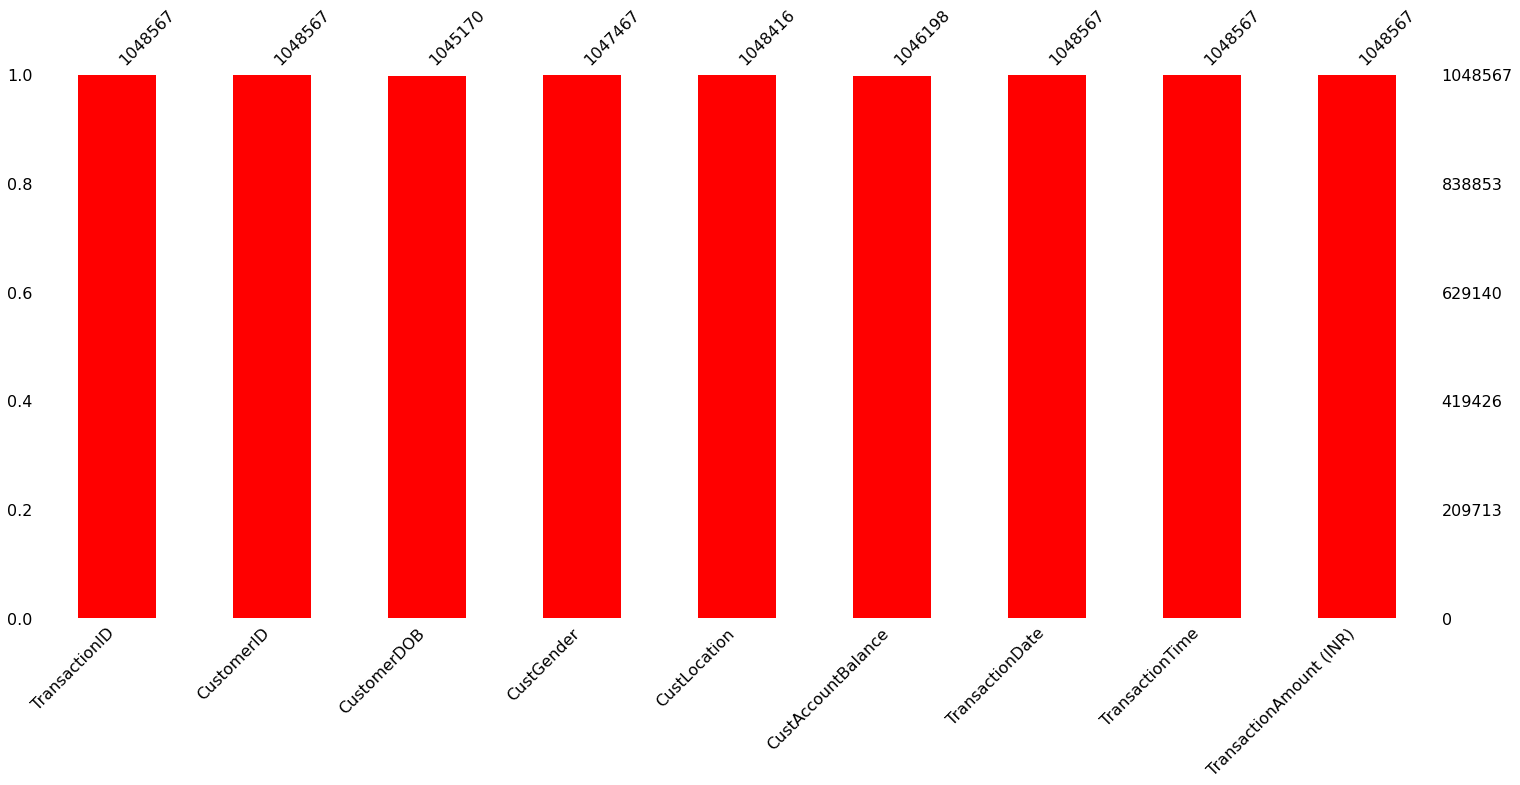

In [ ]:
msno.bar(df_bank, color='red')

Some variables like `CustomerDOB`, `CustGender`, `CustLocation` and `CustAccountBalance` have some null values

In [ ]:
#drop nas
df_bank.dropna(inplace=True) 

# change format of the date
df_bank.CustomerDOB = pd.to_datetime(df_bank.CustomerDOB)
df_bank.loc[df_bank['CustomerDOB'].dt.year >= 2022, ['CustomerDOB']] -= pd.DateOffset(years = 100)

# change format of TransactionDate
df_bank['TransactionDate'] = pd.to_datetime(df_bank['TransactionDate'])

# change format of TransactionTime
df_bank.TransactionTime = df_bank.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S').time())

# drop year = 1800
df_bank.drop(df_bank[df_bank.CustomerDOB.dt.year == 1800].index, axis=0, inplace=True)

In [ ]:
# change the type of TransactionAmount (INR)
df_bank['TransactionAmount (INR)'] = df_bank['TransactionAmount (INR)'].astype(int)

In [ ]:
# we notice that there is row in which a gender is equal to T, so we decided to drop it
df_bank.drop(df_bank[df_bank['CustGender'].isin(['T'])].index,axis=0,inplace=True)

In [ ]:
df_bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762


In [ ]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985322 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            985322 non-null  object        
 1   CustomerID               985322 non-null  object        
 2   CustomerDOB              985322 non-null  datetime64[ns]
 3   CustGender               985322 non-null  object        
 4   CustLocation             985322 non-null  object        
 5   CustAccountBalance       985322 non-null  float64       
 6   TransactionDate          985322 non-null  datetime64[ns]
 7   TransactionTime          985322 non-null  object        
 8   TransactionAmount (INR)  985322 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 107.4+ MB


Now the df is clean

We decided to store the cleaned dataset in our drive folder to avoid the clean procedure again

In [ ]:
df_bank.to_csv('/content/drive/MyDrive/adm hw4/df_cleaned.csv', index=False)

In [ ]:
df_bank = pd.read_csv(r'/content/drive/MyDrive/adm hw4/df_cleaned.csv')

We create the Age column 

In [ ]:
df_bank.CustomerDOB = pd.to_datetime(df_bank.CustomerDOB)
df_bank['CustomerAge'] = (( pd.to_datetime('today') - df_bank.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
df_bank['CustomerAge'] = df_bank['CustomerAge'].astype(int)

To handle the multiple operations for each custumer ID, we select the mode for the variables regarding the gender and age, instead for  Balance and Transaction amount we use the mean.

In [ ]:
# Mean for Transaction
trans = df_bank[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
trans = trans.drop(columns = 'index')
trans.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Avg'}, inplace = True)
df_bank = df_bank.merge(right = trans, on = 'CustomerID')

# Mean for Balance
bal = df_bank[['CustomerID', 'CustAccountBalance']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
bal = bal.drop(columns = 'index')
bal.rename(columns = {'CustAccountBalance' : 'Balance_Avg'}, inplace = True)
df_bank = df_bank.merge(right = bal, on = 'CustomerID')

# Mode for Gender                                                                                                    #if we have two mode, we take the first
g=df_bank[['CustomerID', 'CustGender']].groupby(by = 'CustomerID', as_index = False, sort = False)['CustGender'].agg( lambda x: pd.Series.mode(x)[0]).reset_index() 
g = g.drop(columns = 'index')
g.rename(columns = {'CustGender' : 'Gender_Mode'}, inplace = True)
df_bank = df_bank.merge(right = g, on = 'CustomerID')

# Mode for Age                                                                                                       #if we have two mode, we take the first
ag = df_bank[['CustomerID', 'CustomerAge']].groupby(by = 'CustomerID', as_index = False, sort = False)['CustomerAge'].agg( lambda x: pd.Series.mode(x)[0]).reset_index()
ag = ag.drop(columns = 'index')
ag.rename(columns = {'CustomerAge' : 'Age_Mode'}, inplace = True)
df_bank = df_bank.merge(right = ag, on = 'CustomerID')

In [ ]:
df_bank[['CustomerID','Age_Mode','Gender_Mode','Balance_Avg','Transaction_Avg']].nunique()

CustomerID         839081
Age_Mode               97
Gender_Mode             2
Balance_Avg        264602
Transaction_Avg     27569
dtype: int64

Execpt for `Gender_Mode`, the other variables have too many unique values, we have to divide them into classes, so we create:




####1.   `Balance_class`



In [ ]:
df_bank['Balance_class'] = pd.cut(x=df_bank['Balance_Avg'], bins=[min(df_bank['Balance_Avg'])-1, 1000, 5000, 12000,
                                          30000, 120000,max(df_bank['Balance_Avg'])+1])

In [ ]:
df_bank['Balance_class'].value_counts()

(30000.0, 120000.0]        241800
(12000.0, 30000.0]         216439
(5000.0, 12000.0]          165918
(120000.0, 115035496.1]    145669
(1000.0, 5000.0]           119677
(-1.0, 1000.0]              95819
Name: Balance_class, dtype: int64

####2.  `Transaction_class`

In [ ]:
df_bank['Transaction_class']=pd.cut(x=df_bank['Transaction_Avg'], bins=[min(df_bank['Transaction_Avg'])-1,500,1500,
                                          7000, 12000,max(df_bank['Transaction_Avg'])+1])

In [ ]:
df_bank['Transaction_class'].value_counts()

(-1.0, 500.0]           508892
(500.0, 1500.0]         278648
(1500.0, 7000.0]        167092
(12000.0, 1560035.0]     15403
(7000.0, 12000.0]        15287
Name: Transaction_class, dtype: int64

####3. `Generation`





In [ ]:
df_bank['Generation']=pd.cut(x=df_bank['Age_Mode'], bins=[min(df_bank['Age_Mode'])-1,18,30,
                                          50, 75,max(df_bank['Age_Mode'])+1])

In [ ]:
df_bank['Generation'].value_counts()

(30, 50]     712259
(18, 30]     213839
(50, 75]      55905
(75, 101]      2924
(1, 18]         395
Name: Generation, dtype: int64

Now that we are done with systemizing the data, let's select only the columns that we think are interesting for our purposes

In [ ]:
selected_cols=['CustomerID', 'Generation', 'Transaction_class', 'Balance_class', 'Gender_Mode']

In [ ]:
d=df_bank[selected_cols]
d.drop_duplicates(inplace=True)
d.drop('CustomerID', inplace=True, axis=1)
d

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Generation,Transaction_class,Balance_class,Gender_Mode
0,"(18, 30]","(-1.0, 500.0]","(12000.0, 30000.0]",F
1,"(50, 75]","(12000.0, 1560035.0]","(1000.0, 5000.0]",M
2,"(18, 30]","(-1.0, 500.0]","(12000.0, 30000.0]",F
3,"(30, 50]","(500.0, 1500.0]","(120000.0, 115035496.1]",F
5,"(30, 50]","(1500.0, 7000.0]","(5000.0, 12000.0]",F
...,...,...,...,...
985317,"(30, 50]","(1500.0, 7000.0]","(-1.0, 1000.0]",M
985318,"(18, 30]","(500.0, 1500.0]","(1000.0, 5000.0]",M
985319,"(30, 50]","(500.0, 1500.0]","(5000.0, 12000.0]",M
985320,"(30, 50]","(-1.0, 500.0]","(12000.0, 30000.0]",M


In [ ]:
d.to_csv('/content/drive/MyDrive/adm hw4/df_for1_2.csv', index=False)

In [ ]:
d.isnull().sum()

Generation           0
Transaction_class    0
Balance_class        0
Gender_Mode          0
dtype: int64

## 1.2 Fingerprint hashing

In [4]:
df1 = pd.read_csv(r'/content/drive/MyDrive/adm hw4/df_for1_2.csv')

We change the labels

In [5]:
cleanup = {"Generation":     {"(1, 18]": '1',"(18, 30]": '2', "(30, 50]": '3',
                              "(50, 75]": '4',"(75, 101]": '5',},
           "Transaction_class": {"(-1.0, 500.0]": '1', "(500.0, 1500.0]": '2', "(1500.0, 7000.0]": '3', "(7000.0, 12000.0]": '4',
                                  "(12000.0, 1560035.0]": '5' },
           "Balance_class": {"(-1.0, 1000.0]": '1', "(1000.0, 5000.0]": '2', "(5000.0, 12000.0]": '3', "(12000.0, 30000.0]": '4',
                                  "(30000.0, 120000.0]": '5' , "(120000.0, 115035496.1]" : '6'}}

In [6]:
df1 = df1.replace(cleanup)
df1.head()

,Generation,Transaction_class,Balance_class,Gender_Mode
0,2,1,4,F
1,4,5,2,M
2,2,1,4,F
3,3,2,6,F
4,3,3,3,F


We need the set of all possible outcomes to create the index matrix

In [7]:
Genders=set(df1.Gender_Mode)
Generations=set(df1.Generation)
Balances=set(df1.Balance_class)
Transactions=set(df1.Transaction_class)

Then we turn them into lists

In [8]:
genders=list(Genders)
generations=list(Generations)
balances=list(Balances)
transactions=list(Transactions)

The next step is to obtain the matrix consisting of zero/one, in which we will find 1 as the result if the customer has that characteristic, 0 otherwise.

To do this first we define a function that taken as input an attribute of those defined above (for example Transactions), a dataset and the number that identifies the column related to the attribute in the dataset, provides as Output a vector 0/1 for each class of the attribute

In [9]:
def MapToZerOne(attr, n_col,df):
  n=len(attr) # number of classes of attr
  column=df[df.columns[n_col]] # The array containing all the data that is to be mapped 
  z= np.zeros(len(column)) # A vector of zeros that will later be used to start the stack process

  for i in range(0,n): # For all classes of attr
   temp= np.array([1 if x in attr[i] else 0 for x in np.array(column)]) # Maps in zero/one each client 
   h= np.vstack((z, temp)) # Stacks the old array with the new one
   z=h # Update the old array
  final=h[1:] # Remove the first array of all zeros created at the beginning
  return final

In [14]:
MapToZerOne(genders, 3,df1)

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 1., 1.]])

We can see that `genders` being an attr with only two classes, the two arrays are opposite.

Next, we create a function that uses the one created earlier to make a stack of vectors for each class of our shingles

In [10]:
def get_Matrix(df):
  n_cols=len(df.columns) # Number of df's columns
  l= len(df[df.columns[1]]) # Number of costumers
  init=np.zeros(l) # A vector of zeros that will later be used to start the stack process
  for j in range(0,n_cols): # For each column of the df
    attr=set(df[df.columns[j]]) # Exctract the unique values
    attr=list(attr) # Turn the set into list
    tempr=MapToZerOne(attr,j,df) # Apply MapToZerOne function and obtain an array
    hr= np.vstack((init, tempr)) # Stacks the previous arrays with the new ones
    init=hr # Update the previous arrays
  final2=hr[1:] # Remove the first array of all zeros created at the beginning
  return final2

In [11]:
matrix_onehot=get_Matrix(df1)
matrix_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 1., 1.]])

Although the first two arrays may appear as empty, if we add up each element, we find 1's, but they are very rare:

In [21]:
sum(matrix_onehot[0])

2910.0

In [22]:
sum(matrix_onehot[1])

297.0

The dimensioins match, we have a vector for each class of our shingles

In [ ]:
len(matrix_onehot) == len(genders)+len(generations)+len(balances)+len(transactions)

True

#2 Grouping customers together!

## 2.1 Getting your data + feature engineering


First, we load the  cleaned dataset in point 1.1

In [ ]:
# first we load the df
df_bank = pd.read_csv(r'/content/drive/MyDrive/adm hw4/df_cleaned.csv')

Now we define the seven new features proposed in the homework:

In [ ]:
#1 Number of transactions
temp = df_bank[['CustomerID', 'TransactionID']].groupby(by = 'CustomerID', as_index = False, sort = False).count().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'TransactionID' : 'Transaction_Frequency'}, inplace = True)
df_bank = df_bank.merge(right = temp, on = 'CustomerID')


#2 Number of transactions with a balance bigger than 100 USD
bigger_100=df_bank['TransactionAmount (INR)'].apply(lambda x: x>=100)
bigger_100=bigger_100*1
df_bank.insert(10,"Bigger100",bigger_100)
big = df_bank[['CustomerID', 'Bigger100']].groupby(by = 'CustomerID', as_index = False, sort = False).sum().reset_index()
big = big.drop(columns = 'index')
big.rename(columns = {'Bigger100' : 'Number_Bigger_100'}, inplace = True)
df_bank = df_bank.merge(right = big, on = 'CustomerID')


#3 Average amount of the transactions
trans = df_bank[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
trans = trans.drop(columns = 'index')
trans.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Avg'}, inplace = True)
df_bank = df_bank.merge(right = trans, on = 'CustomerID')


#4 Average balance
bal = df_bank[['CustomerID', 'CustAccountBalance']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
bal = bal.drop(columns = 'index')
bal.rename(columns = {'CustAccountBalance' : 'Balance_Avg'}, inplace = True)
df_bank = df_bank.merge(right = bal, on = 'CustomerID')


#5 Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).
df_bank['Utilisation_0'] = df_bank['CustAccountBalance'] - df_bank['TransactionAmount (INR)']
t = df_bank[['CustomerID', 'Utilisation_0']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
t = t.drop(columns = 'index')
t.rename(columns = {'Utilisation_0' : 'Utilisation_Avg'}, inplace = True)
df_bank = df_bank.merge(right = t, on = 'CustomerID')


#6 Most common gender of the customer
g=df_bank[['CustomerID', 'CustGender']].groupby(by = 'CustomerID', as_index = False, sort = False)['CustGender'].agg( lambda x: pd.Series.mode(x)[0]).reset_index() #if we have two mode, we take the first
g = g.drop(columns = 'index')
g.rename(columns = {'CustGender' : 'Gender_Mode'}, inplace = True)
df_bank = df_bank.merge(right = g, on = 'CustomerID')


#7 Most frequent location of the customer
z=df_bank[['CustomerID', 'CustLocation']].groupby(by = 'CustomerID', as_index = False, sort = False)['CustLocation'].agg( lambda x: pd.Series.mode(x)[0]).reset_index() #if we have two mode, we take the first
z = z.drop(columns = 'index')
z.rename(columns = {'CustLocation' : 'Location_Mode'}, inplace = True)
df_bank = df_bank.merge(right = z, on = 'CustomerID')

In [ ]:
df_bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Transaction_Frequency,Bigger100,Number_Bigger_100,Transaction_Avg,Balance_Avg,Utilisation_0,Utilisation_Avg,Gender_Mode,Location_Mode
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25,1,0,0,25.0,17819.050,17794.05,17794.050,F,JAMSHEDPUR
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999,1,1,1,27999.0,2270.690,-25728.31,-25728.310,M,JHAJJAR
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459,1,1,1,459.0,17874.440,17415.44,17415.440,F,MUMBAI
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060,2,1,2,1469.0,434849.495,864443.21,433380.495,F,MUMBAI
4,T391139,C5342380,1979-05-29,M,MUMBAI,3195.78,2016-08-13,19:41:48,878,2,1,2,1469.0,434849.495,2317.78,433380.495,F,MUMBAI


So, now we finally have the dataset with the 7 features requested.

We decided to store the dataset in our drive folder to avoid the procedure again

In [ ]:
df_bank.to_csv('/content/drive/MyDrive/adm hw4/df7.csv', index=False)

In order not to stress the ram too much, we delete the dataset from the memory

In [ ]:
del df_bank

In [ ]:
df7 = pd.read_csv(r'/content/drive/MyDrive/adm hw4/df7.csv')

The next step is to add at least 20 new features in the dataset

In [ ]:
def generations(age):
    """
    this function takes as input the date of birth and divides it into the various generations
    
    """
    if age=='1800-01-01 00:00:00' or age is np.nan:
        return 'Missing'
    if int(age) in [i for i in range(10,23)]: #we are now assuming that there are not people born before 1922 
        return 'Gen Alpha'
    elif int(age) in [i for i in range(23,46)]:
        return 'Silent Gen'
    elif int(age) in [i for i in range(46,65)]:
        return 'Boomers'
    elif int(age) in [i for i in range(65,81)]:
        return 'Gen X'
    elif int(age) in [i for i in range(81,97)]:
        return 'Gen Y'
    else: # %y goes from 00 to 99 so we only miss the range 1997-2010 (i.e. Gen Z)
        return 'Gen Z'

In [ ]:
#8 Debt for each Custumer ID
debt=df7['Utilisation_Avg'].apply(lambda x: x<0) #if they did, on average, transactions bigger than their balance
debt=debt*1
df7['Debt']=debt

#9 Percentile of Balance_Avg for each Custumer ID
df7['Balance_Avg_Percentile'] = df7.Balance_Avg.rank(pct = True)

#10 Percentile of Utilisation_Avg for each Custumer ID
df7['Utilisation_Avg_Percentile'] = df7.Utilisation_Avg.rank(pct = True)

#11 Average Age for each Custumer ID
df7.CustomerDOB = pd.to_datetime(df7.CustomerDOB)
df7['CustomerAge'] = (( pd.to_datetime('today') - df7.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
df7['CustomerAge'] = df7['CustomerAge'].astype(int)
trans = df7[['CustomerID', 'CustomerAge']].groupby(by = 'CustomerID', as_index = False, sort = False).mean().reset_index()
trans = trans.drop(columns = 'index')
trans.rename(columns = {'CustomerAge' : 'Avg_customerAge'}, inplace = True)
df7 = df7.merge(right = trans, on = 'CustomerID')

#12  Averange Generations for each Custumer ID
gen=df7['Avg_customerAge'].apply(lambda x: generations(x))
df7['Generation']=gen

#13 Sum Transactions for each Custumer ID
trans = df7[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).sum().reset_index()
trans = trans.drop(columns = 'index')
trans.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Sum'}, inplace = True)
df7 = df7.merge(right = trans, on = 'CustomerID')

#14 Standard deviation of Transaction for each Custumer ID
trans = df7[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).std().reset_index()
trans = trans.drop(columns = 'index')
trans.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Std'}, inplace = True)
df7 = df7.merge(right = trans, on = 'CustomerID')
df7['Transaction_Std'] = df7['Transaction_Std'].fillna(0)

#15 Month of transaction
df7['TransactionDate'] = pd.to_datetime(df7['TransactionDate'])
df7['TransactionMonth'] = df7['TransactionDate'].dt.month

#16 percentage of balance in transaction in average (transaction/balance)
df7['Transaction_percent_Avg']= df7['Transaction_Avg']/df7['Balance_Avg']

#17 Number of transactions with a balance bigger than 500 USD
bigger_500=df7['TransactionAmount (INR)'].apply(lambda x: x>=500)
bigger_500=bigger_500*1
df7.insert(10,"Bigger500",bigger_500)
big = df7[['CustomerID', 'Bigger500']].groupby(by = 'CustomerID', as_index = False, sort = False).sum().reset_index()
big = big.drop(columns = 'index')
big.rename(columns = {'Bigger500' : 'Number_Bigger_500'}, inplace = True)
df7 = df7.merge(right = big, on = 'CustomerID')

#18 Number of transactions with a balance bigger than 10000 USD
bigger_10000=df7['TransactionAmount (INR)'].apply(lambda x: x>=10000)
bigger_10000=bigger_10000*1
df7.insert(10,"Bigger10000",bigger_10000)
big = df7[['CustomerID', 'Bigger10000']].groupby(by = 'CustomerID', as_index = False, sort = False).sum().reset_index()
big = big.drop(columns = 'index')
big.rename(columns = {'Bigger10000' : 'Number_Bigger_10000'}, inplace = True)
df7 = df7.merge(right = big, on = 'CustomerID')

#19 Percentile of Age for each Custumer ID
df7['Avg_customerAge_Percentile'] = df7.Avg_customerAge.rank(pct = True)

#20 Max Transaction for each Custumer
temp = df7[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).max().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Max'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#21 Min Transaction for each Custumer
temp = df7[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False).min().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Min'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#22 Max Balance for each Custumer
temp = df7[['CustomerID', 'CustAccountBalance']].groupby(by = 'CustomerID', as_index = False, sort = False).max().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'CustAccountBalance' : 'Balance_Max'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#23 Min Balance for each Custumer
temp = df7[['CustomerID', 'CustAccountBalance']].groupby(by = 'CustomerID', as_index = False, sort = False).min().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'CustAccountBalance' : 'Balance_Min'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#24 Median Balance for each Custumer
temp = df7[['CustomerID', 'CustAccountBalance']].groupby(by = 'CustomerID', as_index = False, sort = False)['CustAccountBalance'].median().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'CustAccountBalance' : 'Balance_Median'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#25 Median Transaction for each Custumer
temp = df7[['CustomerID', 'TransactionAmount (INR)']].groupby(by = 'CustomerID', as_index = False, sort = False)['TransactionAmount (INR)'].median().reset_index()
temp = temp.drop(columns = 'index')
temp.rename(columns = {'TransactionAmount (INR)' : 'Transaction_Median'}, inplace = True)
df7 = df7.merge(right = temp, on = 'CustomerID')

#26 Min Utilization for each Custumer
t = df7[['CustomerID', 'Utilisation_0']].groupby(by = 'CustomerID', as_index = False, sort = False).min().reset_index()
t = t.drop(columns = 'index')
t.rename(columns = {'Utilisation_0' : 'Utilisation_Min'}, inplace = True)
df7 = df7.merge(right = t, on = 'CustomerID')

#27 Max Utilization for each Custumer
t = df7[['CustomerID', 'Utilisation_0']].groupby(by = 'CustomerID', as_index = False, sort = False).max().reset_index()
t = t.drop(columns = 'index')
t.rename(columns = {'Utilisation_0' : 'Utilisation_Max'}, inplace = True)
df7 = df7.merge(right = t, on = 'CustomerID')

#28 Median Utilization for each Custumer
t = df7[['CustomerID', 'Utilisation_0']].groupby(by = 'CustomerID', as_index = False, sort = False)['Utilisation_0'].median().reset_index()
t = t.drop(columns = 'index')
t.rename(columns = {'Utilisation_0' : 'Utilisation_Median'}, inplace = True)
df7 = df7.merge(right = t, on = 'CustomerID')


In [ ]:
df7.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),Transaction_Frequency,...,Avg_customerAge_Percentile,Transaction_Max,Transaction_Min,Balance_Max,Balance_Min,Balance_Median,Transaction_Median,Utilisation_Min,Utilisation_Max,Utilisation_Median
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25,1,...,0.038146,25,25,17819.05,17819.05,17819.050,25.0,17794.05,17794.05,17794.050
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999,1,...,0.988004,27999,27999,2270.69,2270.69,2270.690,27999.0,-25728.31,-25728.31,-25728.310
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,14:27:12,459,1,...,0.009189,459,459,17874.44,17874.44,17874.440,459.0,17415.44,17415.44,17415.440
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060,2,...,0.886232,2060,878,866503.21,3195.78,434849.495,1469.0,2317.78,864443.21,433380.495
4,T391139,C5342380,1979-05-29,M,MUMBAI,3195.78,2016-08-13,19:41:48,878,2,...,0.886232,2060,878,866503.21,3195.78,434849.495,1469.0,2317.78,864443.21,433380.495


During the procedures, some extra columns were created and now it is time to remove them

In [ ]:
colstoremove=['Bigger100',
 'Bigger10000',
 'Bigger500',
 'CustAccountBalance',
 'CustGender',
 'CustLocation',
 'CustomerAge',
 'CustomerDOB',
 'TransactionAmount (INR)',
 'TransactionDate',
 'TransactionID',
 'TransactionMonth',
 'TransactionTime',
 'Utilisation_0']

In [ ]:
def removeColList(df,colstoremove):
  """
  Given a list of columns and a dataframe, this function removes the required columns from the dataframe
  """
  my_cols = set(df.columns)
  for i in colstoremove:
   my_cols.remove(i)
  my_cols = list(my_cols)
  Final_df = df[my_cols]
  return Final_df


In [ ]:
Final_df = removeColList(df7,colstoremove)

In [ ]:
Final_df.head()

,Balance_Median,Balance_Avg_Percentile,Avg_customerAge_Percentile,Location_Mode,Utilisation_Avg,Utilisation_Min,Balance_Max,Avg_customerAge,Transaction_Min,Number_Bigger_10000,...,Transaction_Sum,Gender_Mode,Balance_Min,Transaction_Median,Transaction_Avg,Transaction_Std,Generation,Debt,Transaction_percent_Avg,Utilisation_Avg_Percentile
0,17819.050,0.481766,0.038146,JAMSHEDPUR,17794.050,17794.05,17819.05,28.0,25,0,...,25,F,17819.05,25.0,25.0,0.000000,Silent Gen,0,0.001403,0.495681
1,2270.690,0.138440,0.988004,JHAJJAR,-25728.310,-25728.31,2270.69,66.0,27999,1,...,27999,M,2270.69,27999.0,27999.0,0.000000,Gen X,1,12.330613,0.000902
2,17874.440,0.482572,0.009189,MUMBAI,17415.440,17415.44,17874.44,26.0,459,0,...,459,F,17874.44,459.0,459.0,0.000000,Silent Gen,0,0.025679,0.490606
3,434849.495,0.957291,0.886232,MUMBAI,433380.495,2317.78,866503.21,46.5,878,0,...,2938,F,3195.78,1469.0,1469.0,835.800215,Boomers,0,0.003378,0.957365
4,434849.495,0.957291,0.886232,MUMBAI,433380.495,2317.78,866503.21,46.5,878,0,...,2938,F,3195.78,1469.0,1469.0,835.800215,Boomers,0,0.003378,0.957365


We stored the final Dataset in our drive

In [ ]:
Final_df.to_csv('/content/drive/MyDrive/adm hw4/Final_df.csv', index=False)

In [ ]:
del Final_df

## 2.2 Choose your features (variables)!

First we load the dataset

In [ ]:
Fd = pd.read_csv(r'/content/drive/MyDrive/adm hw4/Final_df.csv')

In [ ]:
Fd.drop_duplicates(inplace=True)
Fd.dropna(inplace=True)
Fd.set_index('CustomerID',inplace=True)

Then we select the columns

In [ ]:
Fd.columns

Index(['Balance_Median', 'Balance_Avg_Percentile',
       'Avg_customerAge_Percentile', 'Location_Mode', 'Utilisation_Avg',
       'Utilisation_Min', 'Balance_Max', 'Avg_customerAge', 'Transaction_Min',
       'Number_Bigger_10000', 'Transaction_Max', 'Utilisation_Median',
       'Utilisation_Max', 'Transaction_Frequency', 'Number_Bigger_500',
       'Number_Bigger_100', 'Balance_Avg', 'Transaction_Sum', 'Gender_Mode',
       'Balance_Min', 'Transaction_Median', 'Transaction_Avg',
       'Transaction_Std', 'Generation', 'Debt', 'Transaction_percent_Avg',
       'Utilisation_Avg_Percentile'],
      dtype='object')

In [ ]:
cols_to_norm = ['Utilisation_Max',  'Balance_Median',
       'Avg_customerAge', 'Balance_Max', 'Number_Bigger_500', 'Balance_Min',
       'Utilisation_Median', 'Transaction_Frequency',
        'Utilisation_Avg', 'Transaction_Min',
       'Number_Bigger_10000', 'Transaction_Sum', 'Transaction_Median',
       'Number_Bigger_100', 'Balance_Avg', 'Transaction_Max',
       'Transaction_Avg', 'Utilisation_Min','Utilisation_Avg_Percentile','Utilisation_Avg_Percentile', 'Balance_Avg_Percentile','Transaction_Std']

we scale our features with the scikit-learn package

In [ ]:
Fds=StandardScaler().fit_transform(Fd[cols_to_norm].to_numpy())

Since PCA can only be applied on numeric variables, we decide to eliminate all variables that are not. so we remain only with the features in the `Fds` dataset

In [ ]:
Fds = pd.DataFrame(Fds, columns=cols_to_norm)
Fds

,Utilisation_Max,Balance_Median,Avg_customerAge,Balance_Max,Number_Bigger_500,Balance_Min,Utilisation_Median,Transaction_Frequency,Utilisation_Avg,Transaction_Min,Number_Bigger_10000,Transaction_Sum,Transaction_Median,Number_Bigger_100,Balance_Avg,Transaction_Max,Transaction_Avg,Utilisation_Min,Utilisation_Avg_Percentile,Utilisation_Avg_Percentile,Balance_Avg_Percentile,Transaction_Std
0,-0.115772,-0.110569,-1.125945,-0.117390,-0.953556,-0.098038,-0.108797,-0.400542,-0.110195,-0.214271,-0.160579,-0.251284,-0.234566,-1.818622,-0.111969,-0.243202,-0.236314,-0.096229,0.029822,0.029822,-0.016879,-0.112608
1,-0.165224,-0.130388,3.395195,-0.135049,0.774670,-0.118601,-0.164296,-0.400542,-0.165571,4.539665,6.177371,3.931646,4.404349,0.031866,-0.131744,3.977559,4.391156,-0.153810,-1.663313,-1.663313,-1.190474,-0.112608
2,-0.116202,-0.110498,-1.363900,-0.117327,-0.953556,-0.097964,-0.109280,-0.400542,-0.110677,-0.140516,-0.160579,-0.186388,-0.162596,0.031866,-0.111898,-0.177720,-0.164522,-0.096730,0.012457,0.012457,-0.014123,-0.112608
3,0.846226,0.421014,1.075137,0.846510,2.502896,-0.117377,0.421153,1.897625,0.418578,-0.069311,-0.160579,0.184295,0.004892,1.882353,0.418433,0.063842,0.002553,-0.116704,1.609706,1.609706,1.608613,0.283006
4,-0.130363,-0.124723,-0.293103,-0.130002,0.774670,-0.112724,-0.125173,-0.400542,-0.126534,0.080917,-0.160579,0.008448,0.053480,0.031866,-0.126092,0.018879,0.051021,-0.113219,-0.843167,-0.843167,-0.755006,-0.112608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839073,-0.138871,-0.132690,0.658716,-0.137100,0.774670,-0.120989,-0.134721,-0.400542,-0.136061,0.291304,-0.160579,0.193566,0.258777,0.031866,-0.134041,0.205670,0.255811,-0.123125,-1.627866,-1.627866,-1.408375,-0.112608
839074,-0.136317,-0.131736,-0.887990,-0.136251,0.774670,-0.120000,-0.131854,-0.400542,-0.133201,0.036393,-0.160579,-0.030728,0.010033,0.031866,-0.133090,-0.020652,0.007681,-0.120151,-1.517168,-1.517168,-1.305384,-0.112608
839075,-0.128223,-0.123550,-0.650035,-0.128957,0.774670,-0.111506,-0.122771,-0.400542,-0.124137,-0.082736,-0.160579,-0.135548,-0.106214,0.031866,-0.124921,-0.126420,-0.108279,-0.110726,-0.671814,-0.671814,-0.679128,-0.112608
839076,-0.105481,-0.098469,-0.769013,-0.106609,-0.953556,-0.085484,-0.097247,-0.400542,-0.098671,-0.140346,-0.160579,-0.186239,-0.162430,0.031866,-0.099896,-0.177569,-0.164357,-0.084246,0.356921,0.356921,0.333810,-0.112608


`Fds` is our dataset that we use for the Principal Component Analysis (PCA).


In [ ]:
Fds.to_csv('/content/drive/MyDrive/adm hw4/FDS_scaled.csv', index=False)

In [ ]:
Fds= pd.read_csv(r'/content/drive/MyDrive/adm hw4/FDS_scaled.csv')

In [ ]:
pca = PCA()
pca.fit(Fds)

PCA()

In [ ]:
cumulatevariance=np.cumsum(pca.explained_variance_ratio_)
cumulatevariance

array([0.36280824, 0.60569387, 0.74550976, 0.83112996, 0.87832204,
       0.91966715, 0.94721786, 0.97286015, 0.98630114, 0.99856206,
       0.99912989, 0.99960827, 0.99992175, 0.99999194, 0.9999974 ,
       0.99999876, 0.99999987, 0.99999999, 1.        , 1.        ,
       1.        , 1.        ])

In [ ]:
fig=px.area(
    x=range(1, cumulatevariance.shape[0] + 1),
    y=cumulatevariance,
    labels={"x": "Number of Components", "y": "Cumulative Explained Variance"}
)
fig.add_vline(x=3, line_width=3, line_color="Orange")

since the package `plotly.express` has visualization problems with GitHub, we have also included the picture of the graph in the notebook

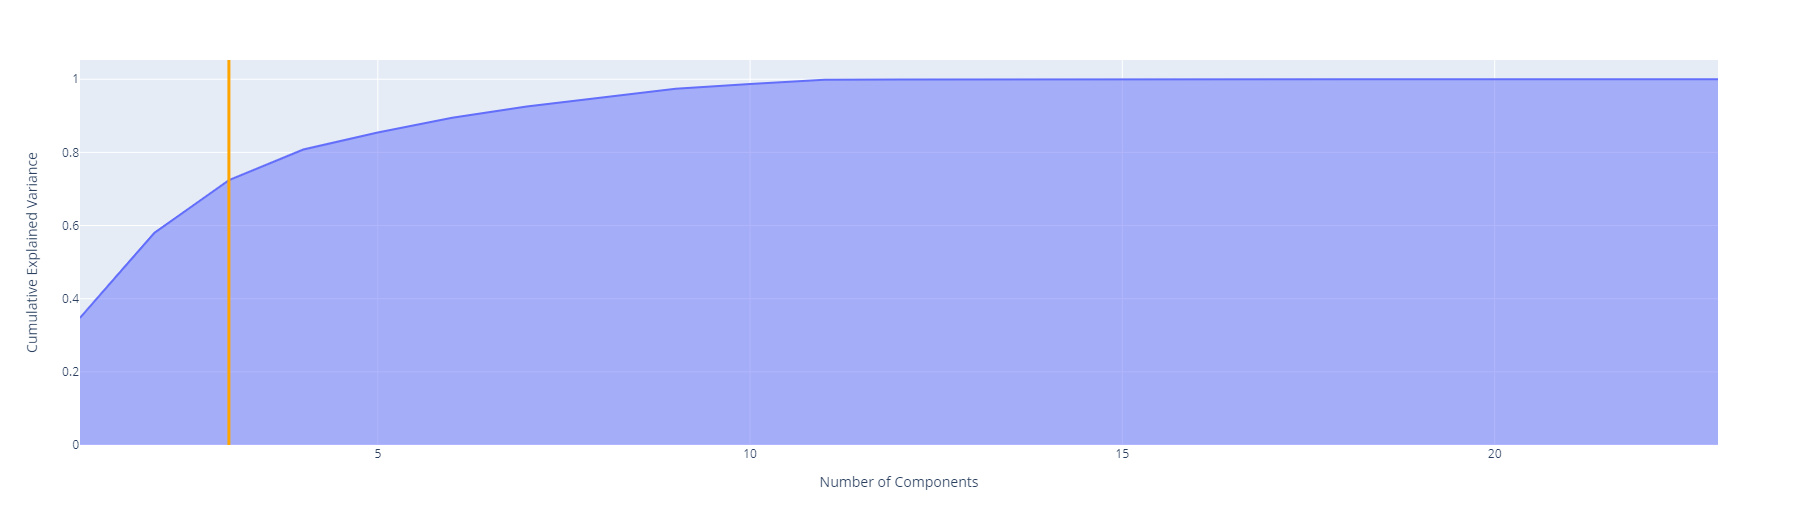

We have that the threshold of 70% of total variance is reached after 3 components.

So we extract the first 3 components by creating a new dataset

In [ ]:
df_c = pd.DataFrame(pca.transform(Fds))
df_c = df_c.iloc[0:, :3]

In [ ]:
df_c

,0,1,2
0,-0.553798,-0.830687,0.778555
1,1.019988,10.456264,3.524781
2,-0.498669,-0.555498,0.383484
3,1.907916,0.724195,-3.851677
4,-0.605334,0.041669,1.119952
...,...,...,...
839073,-0.758507,0.399970,2.145569
839074,-0.896436,-0.158291,2.137264
839075,-0.626336,-0.274727,0.906058
839076,-0.307044,-0.480915,-0.221679


To avoid redoing these procedures we decide to save the dataset in our drive

In [ ]:
df_c.to_csv('/content/drive/MyDrive/adm hw4/PCA_df.csv', index=False)

## 2.3 Clustering!

##### kmeans_python_basic

The kmeans with MapReduce consists in 5 steps:
* **STEP 1** : Select k initial means uniformly at random from the Dataset
* **STEP 2** : Apply the MapReduce
* **STEP 3** : Compute the new means from the MapReduce
* **STEP 4** : Save the new means and broadcast them
* **STEP 5** : Untill the convergence, repeat step 2,3 and 4

In [ ]:
from scipy.spatial.distance import cdist 

In [ ]:
df_c = pd.read_csv(r'/content/drive/MyDrive/adm hw4/PCA_df.csv')

In [ ]:
df_c=df_c.to_numpy()

In [ ]:
def get_InitialMeans(Dataset,k):
  """ this function is responsible for the first step
  """
  i=np.random.randint(0,len(Dataset), k)
  c=Dataset[i, :]
  return c

In [ ]:
def k_means_Map(Dataset,centroids):
  """ this function is responsible for the Map part in the second step
  """
   keyes = np.argmin(cdist(XA=Dataset, XB=centroids, metric= 'euclidean'),axis=1)
   final_list=[]
   for i in range(0, len(Dataset)):
    final_list.append([keyes[i],Dataset[i].tolist()]) 
   return keyes, final_list

In [ ]:
def k_means_Reduce(keyes,map_list,k):
  """ this function is responsible for the Reduce part in the second step
  """
  reduce_list=[]
  partition_dimension=[]
  for i in range(0,k):
    lst = np.array([item[1]  for item in map_list if item[0]==i])
    partition_dimension.append([i+1,len(lst)])
    reduce_list.append([i+1,lst.sum(axis=0)])
  return reduce_list, partition_dimension

In [ ]:
def get_NewMeans(sum_values,dim_partition,k):
  """ this function is responsible for the third step
  """
  means=[]
  for i in range(1,k+1):
    compute_mean=[]
    dim=[item[1] for item in dim_partition if item[0]==i]
    compute_mean=[item[1]/dim[0]  for item in sum_values if item[0]==i]
    means.append(compute_mean)
    means_list = [arr[0].tolist() for arr in means]
  return means_list


In [ ]:
def k_means(Dataset,k,iterations):
    """ this is our kmeans, uses the functions defined above and stops after a fixed number of iterations
    """

    # STEP 1 
    init_means = get_InitialMeans(Dataset,k)
    

    for _ in range(iterations): # Repeat steps for the number of iterations
      # STEP 2 
      keyes, mapped_list = k_means_Map(Dataset,init_means)
      sum_v, dim_p = k_means_Reduce(keyes,mapped_list,k)

      # STEP 3 
      new_means=get_NewMeans(sum_v,dim_p,k)

      init_means=new_means
    # STEP 4 repeate the step with an iterative function for find the optimal partition
    df = pd.DataFrame(Dataset, columns = ['Column_A','Column_B','Column_C'])
    df['Cluster']= keyes
    return mapped_list, new_means, keyes, df

In [ ]:
mapped_list, new_means, keyes, df_k = k_means(df_c,10,10)

##### PySpark

In [ ]:
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 38 kB/s 
     |████████████████████████████████| 199 kB 61.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=7da6fe3f1083487644116755fbd26166d41f78d74c927b07340281de58ef36b8
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
import pyspark 

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark= SparkSession.builder.appName('kmeans').getOrCreate()

In [ ]:
data = spark.read.csv('/content/drive/MyDrive/adm hw4/PCA_df.csv')
data = data.rdd

In [ ]:
def get_InitialMeans_Spark(Dataset,k):
  i= Dataset.takeSample(False, k)
  return i

In [ ]:
i= get_InitialMeans_Spark(data,10)
i

[Row(_c0='0.5827088553863867', _c1='-0.08329363061391225', _c2='-2.214041582664777'),
 Row(_c0='-0.6375570634346432', _c1='0.13377228326250545', _c2='1.396411951878798'),
 Row(_c0='-0.26544417414227733', _c1='-0.09627994541829243', _c2='-0.3181816793243201'),
 Row(_c0='-0.3501720047434864', _c1='0.4684689676449441', _c2='0.47162938493186424'),
 Row(_c0='-0.06972710405505216', _c1='1.1824106543376554', _c2='-0.926921271739339'),
 Row(_c0='-1.0356187127510685', _c1='-0.804333695024544', _c2='2.41907833888463'),
 Row(_c0='-0.10432428883182064', _c1='0.08459608869809793', _c2='-0.7522892116351115'),
 Row(_c0='0.9348028156071454', _c1='1.7216763721687272', _c2='-3.9504608727283776'),
 Row(_c0='-0.35909871466615956', _c1='1.0756519604359727', _c2='0.3821387750437541'),
 Row(_c0='1.3239331580213525', _c1='0.9566933072958292', _c2='-2.592059987618391')]

In [ ]:
list(enumerate(i))

[(0,
  Row(_c0='0.5827088553863867', _c1='-0.08329363061391225', _c2='-2.214041582664777')),
 (1,
  Row(_c0='-0.6375570634346432', _c1='0.13377228326250545', _c2='1.396411951878798')),
 (2,
  Row(_c0='-0.26544417414227733', _c1='-0.09627994541829243', _c2='-0.3181816793243201')),
 (3,
  Row(_c0='-0.3501720047434864', _c1='0.4684689676449441', _c2='0.47162938493186424')),
 (4,
  Row(_c0='-0.06972710405505216', _c1='1.1824106543376554', _c2='-0.926921271739339')),
 (5,
  Row(_c0='-1.0356187127510685', _c1='-0.804333695024544', _c2='2.41907833888463')),
 (6,
  Row(_c0='-0.10432428883182064', _c1='0.08459608869809793', _c2='-0.7522892116351115')),
 (7,
  Row(_c0='0.9348028156071454', _c1='1.7216763721687272', _c2='-3.9504608727283776')),
 (8,
  Row(_c0='-0.35909871466615956', _c1='1.0756519604359727', _c2='0.3821387750437541')),
 (9,
  Row(_c0='1.3239331580213525', _c1='0.9566933072958292', _c2='-2.592059987618391'))]

In [ ]:
_
import spark.ml.linalg.Vector
import org.apache.spark.ml.linalg.Vectors

ModuleNotFoundError: ignored

In [ ]:
sqrt(Vectors.sqdist(v1, v2)

In [ ]:
def k_means_Map(Dataset,centroids):
   assigned_c=0
   min_dist=float('inf') 
    
   keyes = np.argmin(cdist(XA=Dataset, XB=centroids, metric= 'euclidean'),axis=1)
   final_list=[]
   for i in range(0, len(Dataset)):
    final_list.append([keyes[i],Dataset[i].tolist()]) 
   return keyes, final_list

In [ ]:
def k_means_Map(Dataset,centroids):
   assigned_c=0
   min_dist=float('inf') 
   for i in range(0,len(centroids)+1):
     d_o=0
     for j in range(0,len(Dataset)+1):
      d_n= (Dataset[j] - centroids[i][1][j])**2
      d=d_n+d_o
      d_o=d
   return d


### 2.3.4

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

We Used the k_means ++ from the scikit-learn library

Inside the `KElbowVisualizer` method there are three different metric to evaluate the number of clusters:

*   distortion
*   calinski_harabasz
*   silhouette

We used the first two.




We want to apply the reported metrics to both datasets (the one resulting from the pca (`df_c`) and `Final_df` from the point 2.1) to see the number of clusters suggested in the two cases. 

But we will only apply the kmeans to the `Final_df`

#### `df_c`

In [ ]:
df_c = pd.read_csv(r'/content/drive/MyDrive/adm hw4/PCA_df.csv')

In [ ]:
df_c=df_c.to_numpy()

Let's apply kmeans++ :

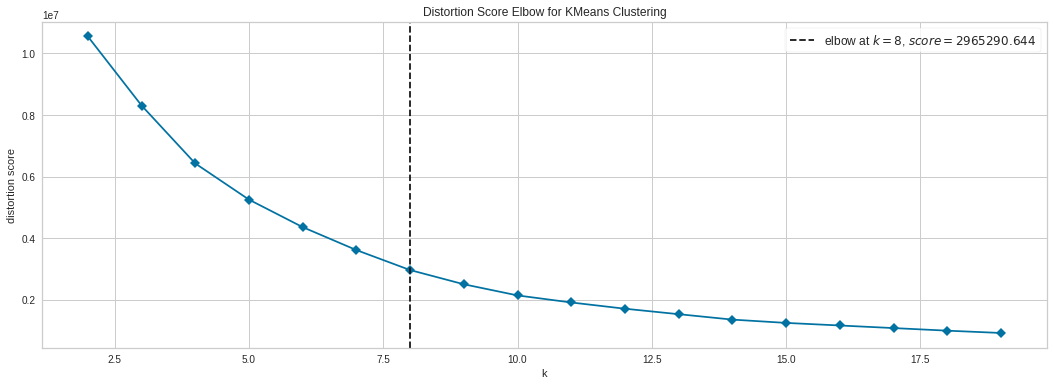

In [ ]:
plt.figure(figsize = (18, 6))
model = KMeans(init = 'k-means++')
vd = KElbowVisualizer(model, k = (2,20), metric = 'distortion', timings = False)
vd.fit(df_c)
vd.show()

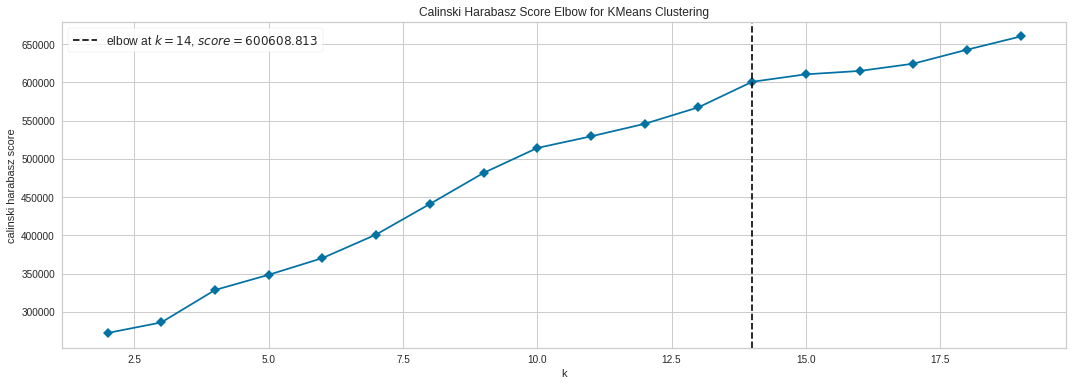

In [ ]:
plt.figure(figsize = (18, 6))
model = KMeans(init = 'k-means++')
va = KElbowVisualizer(model, k = (2,20), metric = 'calinski_harabasz', timings = False)
va.fit(df_c)
va.show()

The two measurements suggest us two different values, namely 8 and 14 respectively.



#### `Final_df`

We load the dataset and apply the classical cleaning operations 

In [ ]:
dataset = pd.read_csv(r'/content/drive/MyDrive/adm hw4/Final_df.csv')

In [ ]:
dataset.drop_duplicates(inplace=True)
dataset.dropna(inplace=True)
dataset.set_index('CustomerID',inplace=True)

We immediately divide the variable `Transaction_percent_Avg` in 4 classes

In [ ]:
dataset.Transaction_percent_Avg = pd.cut(dataset.Transaction_percent_Avg, bins=[min(dataset.Transaction_percent_Avg)-1, 25, 50, 75, 100, max(dataset.Transaction_percent_Avg)])

We save a copy of our dataset before the standardize operations

In [ ]:
dataset_k=dataset

we apply some feature engeniring operations:
* Recode `Gender_Mode` into 0/1

In [ ]:
cleanup_g = {"Gender_Mode" : {'F':0, 'M':1}}

In [ ]:
dataset = dataset.replace(cleanup_g)

* Change the strings of `Location_Mode`, `Transaction_percent_Avg` and `Generation` to numerical categorical values



In [ ]:
dataset.Location_Mode = pd.Categorical(dataset.Location_Mode)
dataset['Location_Mode'] = dataset.Location_Mode.cat.codes

In [ ]:
dataset.Transaction_percent_Avg = pd.Categorical(dataset.Transaction_percent_Avg)
dataset.Transaction_percent_Avg = dataset.Transaction_percent_Avg.cat.codes

In [ ]:
dataset.Generation = pd.Categorical(dataset.Generation)
dataset['Generation'] = dataset.Generation.cat.codes

In [ ]:
dataset.dropna(inplace=True)

* As before we standardize the variables, this time in an interval [0,1]

In [ ]:
cols_to_norm = ['Utilisation_Max',  'Balance_Median',
       'Avg_customerAge', 'Balance_Max', 'Number_Bigger_500', 'Balance_Min',
       'Utilisation_Median', 'Transaction_Frequency',
       'Debt', 'Utilisation_Avg', 'Transaction_Min',
       'Number_Bigger_10000', 'Transaction_Sum', 'Transaction_Median',
       'Number_Bigger_100', 'Balance_Avg', 'Transaction_Max',
       'Transaction_Avg', 'Utilisation_Min','Utilisation_Avg_Percentile','Utilisation_Avg_Percentile', 'Balance_Avg_Percentile','Transaction_Std']

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
dataset[cols_to_norm]=min_max_scaler.fit_transform(dataset[cols_to_norm])

In [ ]:
dataset

,Balance_Median,Balance_Avg_Percentile,Avg_customerAge_Percentile,Location_Mode,Utilisation_Avg,Utilisation_Min,Balance_Max,Avg_customerAge,Transaction_Min,Number_Bigger_10000,Transaction_Max,Utilisation_Median,Utilisation_Max,Transaction_Frequency,Number_Bigger_500,Number_Bigger_100,Balance_Avg,Transaction_Sum,Gender_Mode,Balance_Min,Transaction_Median,Transaction_Avg,Transaction_Std,Generation,Debt,Transaction_percent_Avg,Utilisation_Avg_Percentile
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,
C5841053,0.000155,0.481375,0.038146,3072,0.013173,0.013173,0.000155,0.265306,0.000016,0.0,0.000016,0.013173,0.013173,0.0,0.0,0.000000,0.000155,0.000016,0,0.000155,0.000016,0.000016,0.000000,5,0.0,0,0.495680
C2142763,0.000020,0.137788,0.988004,3127,0.012800,0.012800,0.000020,0.653061,0.017948,0.5,0.017948,0.012800,0.012800,0.0,0.2,0.166667,0.000020,0.017948,1,0.000020,0.017948,0.017948,0.000000,2,1.0,0,0.000901
C4417068,0.000155,0.482182,0.009189,4530,0.013170,0.013170,0.000155,0.244898,0.000294,0.0,0.000294,0.013170,0.013170,0.0,0.0,0.166667,0.000155,0.000294,0,0.000155,0.000294,0.000294,0.000000,5,0.0,0,0.490606
C5342380,0.003780,0.957262,0.886232,4530,0.016739,0.013040,0.007532,0.454082,0.000563,0.0,0.001320,0.016739,0.020437,0.2,0.4,0.333333,0.003780,0.001883,0,0.000028,0.000942,0.000942,0.001633,0,0.0,0,0.957365
C9031234,0.000058,0.265278,0.461564,4859,0.013063,0.013063,0.000058,0.336735,0.001129,0.0,0.001129,0.013063,0.013063,0.0,0.2,0.166667,0.000058,0.001129,0,0.000058,0.001129,0.001129,0.000000,5,0.0,0,0.240569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5028150,0.000004,0.073994,0.817752,5688,0.012999,0.012999,0.000004,0.418367,0.001923,0.0,0.001923,0.012999,0.012999,0.0,0.2,0.166667,0.000004,0.001923,1,0.000004,0.001923,0.001923,0.000000,5,1.0,0,0.011259
C1034220,0.000011,0.104146,0.115802,672,0.013018,0.013018,0.000011,0.285714,0.000962,0.0,0.000962,0.013018,0.013018,0.0,0.2,0.166667,0.000011,0.000962,1,0.000011,0.000962,0.000962,0.000000,5,1.0,0,0.043608
C8020229,0.000066,0.287492,0.245361,4957,0.013079,0.013079,0.000066,0.306122,0.000512,0.0,0.000512,0.013079,0.013079,0.0,0.2,0.166667,0.000066,0.000512,1,0.000066,0.000512,0.000512,0.000000,5,0.0,0,0.290643


We can now therefore apply the kmeans

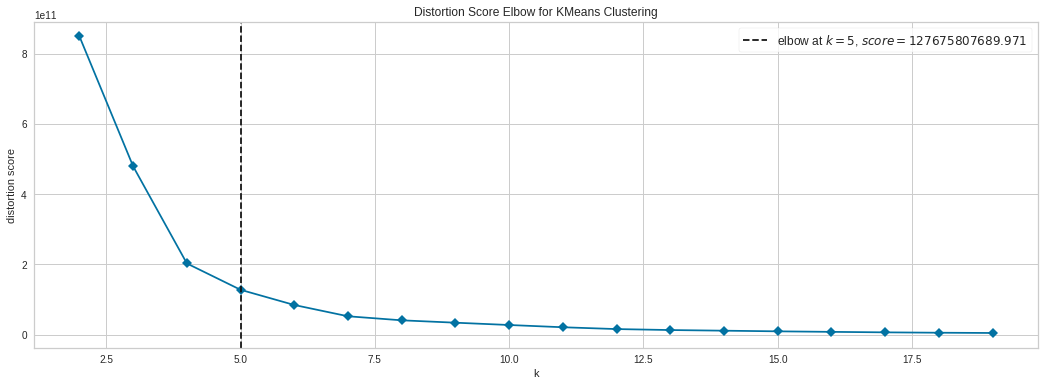

In [ ]:
plt.figure(figsize = (18, 6))
m = KMeans(init = 'k-means++')
elbow = KElbowVisualizer(m, k = (2,20), metric = 'distortion', timings = False)
elbow.fit(dataset)
elbow.show()

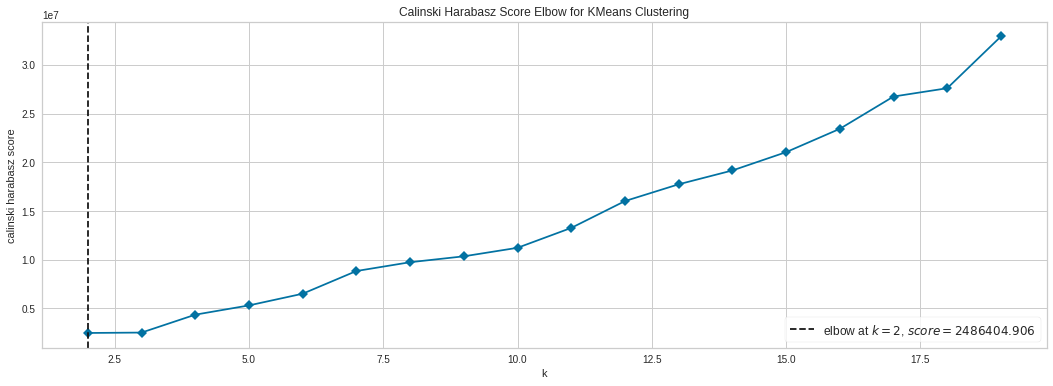

In [ ]:
plt.figure(figsize = (18, 6))
m1 = KMeans(init = 'k-means++')
calinski = KElbowVisualizer(m1, k = (2,20), metric = 'calinski_harabasz', timings = False)
calinski.fit(dataset)
calinski.show()

The two reported metrics again suggest to us two different numbers of clusters: 5 and 2
We chose to place k=4 as it is a value between the two.

It must be remembered, however, that the suggested cluster value in this dataset is lower than that calculated in the dataset where pca was applied.

In [ ]:
kmeans = KMeans(init = 'k-means++',n_clusters = 4)
kmeans.fit(dataset)

KMeans(n_clusters=4)

We extract the lable for each client and insert it into a column of the dataset

In [ ]:
dataset_k["cluster"] = kmeans.labels_

In [ ]:
dataset["cluster"] = kmeans.labels_

We save the dataset for use in the next step

In [ ]:
dataset_k.to_csv('/content/drive/MyDrive/adm hw4/kmeans_dataset.csv', index=False)

In [ ]:
dataset.to_csv('/content/drive/MyDrive/adm hw4/dataset_for_evaluation.csv', index=False)

# 2.4

In [ ]:
datak = pd.read_csv(r'/content/drive/MyDrive/adm hw4/kmeans_dataset.csv')

In [ ]:
datak.columns

Index(['Balance_Median', 'Balance_Avg_Percentile',
       'Avg_customerAge_Percentile', 'Location_Mode', 'Utilisation_Avg',
       'Utilisation_Min', 'Balance_Max', 'Avg_customerAge', 'Transaction_Min',
       'Number_Bigger_10000', 'Transaction_Max', 'Utilisation_Median',
       'Utilisation_Max', 'Transaction_Frequency', 'Number_Bigger_500',
       'Number_Bigger_100', 'Balance_Avg', 'Transaction_Sum', 'Gender_Mode',
       'Balance_Min', 'Transaction_Median', 'Transaction_Avg',
       'Transaction_Std', 'Generation', 'Debt', 'Transaction_percent_Avg',
       'Utilisation_Avg_Percentile', 'cluster'],
      dtype='object')

We think that the 3 features that are important to identify the cluster of the customer are : `Transaction_Frequency`, `Number_Bigger_500` and `Utilisation_Max`



#### `Transaction_Frequency`

Let's reduce the column: 

In [ ]:
modf= {"Transaction_Frequency": {1:'1',2:'2',3:'3',4:'4+', 5:'4+', 6:'4+'}}

In [ ]:
datak=datak.replace(modf)

Now we can plot the  first Pivot table

In [ ]:
round(pd.crosstab(index=datak["cluster"], columns=datak['Transaction_Frequency'],normalize='index', margins=True)*100,2)

Transaction_Frequency,1,2,3,4+
cluster,,,,
0,75.86,20.55,3.23,0.36
1,90.76,8.50,0.69,0.06
2,82.79,15.38,1.69,0.15
3,98.02,1.89,0.08,0.01
All,84.64,13.48,1.70,0.17


Although in all clusters the individuals who made transactions = 1 are always greater than the others, we can see that cluster 2 is composed almost predominantly of people with the transition frequency = 1.

Furthermore, in clusters 0 and 3, we can see rather high values relative to the mean for frequencies=2 and low values for frequencies = 1

#### `Number_Bigger_500`

As before, we reduce the columns:

In [ ]:
modb= {"Number_Bigger_500": {0:'0',1:'1',2:'2',3:'3+',4:'3+', 5:'3+'}}

In [ ]:
datak=datak.replace(modb)

In [ ]:
round(pd.crosstab(index=datak["cluster"], columns=datak['Number_Bigger_500'],normalize='index', margins=True)*100,2)

Number_Bigger_500,0,1,2,3+
cluster,,,,
0,47.75,46.17,5.65,0.44
1,47.89,49.70,2.30,0.11
2,48.90,46.85,4.02,0.23
3,56.38,43.21,0.40,0.01
All,48.94,47.20,3.63,0.24


Even if the differences in the data are not huge, we can see that in cluster 2 there are on average 10% more individuals with N_Bigger_500 = 0 than in the other clusters, also less than 0.5% of the individuals have N_bigger_500 >= 2 when in the other clusters the average is about 4%

#### `Utilisation_Max`



This is a continuous variable, so first we need to understand the distribution before dividing it into categories: 

In [ ]:
datak.Utilisation_Max.describe()

count    8.390780e+05
mean     1.196845e+05
std      8.800945e+05
min     -1.517546e+06
25%      4.848712e+03
50%      1.808086e+04
75%      6.222816e+04
max      1.150349e+08
Name: Utilisation_Max, dtype: float64

We divided the variable into 4 categories:
* In the first we included all negative values
* In the second we go from zero to 10000 which is a value between the first and second quartiles
* As right boundary for the third group we used a number slightly lower than the third quartile
* The last class goes up to the maximum of the distribution

In [ ]:
datak['Utilisation_Max_r'] = pd.cut(datak.Utilisation_Max, [min(datak.Utilisation_Max)-1,0,10000,60000,max(datak.Utilisation_Max)], include_lowest=True)

In [ ]:
round(pd.crosstab(index=datak["cluster"], columns=datak['Utilisation_Max_r'],normalize='index', margins=True)*100,2)

Utilisation_Max_r,"(-1517547.111, 0.0]","(0.0, 10000.0]","(10000.0, 60000.0]","(60000.0, 115034895.1]"
cluster,,,,
0,7.81,27.57,38.56,26.06
1,8.64,27.55,36.17,27.64
2,8.10,28.56,37.66,25.68
3,10.77,35.81,35.90,17.52
All,8.45,28.63,37.29,25.63


In cluster 2 we can see that in the two lowest classes of utilization_max there are more individuals (10.8% in the first and 35.8% in the second) in proportion to the other groups ( average of about 8 and 28, respectively). also in this cluster, we can see a lower presence of individuals belonging to the highest class ( 17% compared to the average of 25).

To estimate clustering algorithm performance we load the dataset stored before in 2.3:

In [ ]:
d_performance=pd.read_csv(r'/content/drive/MyDrive/adm hw4/dataset_for_evaluation.csv')

let's look at two metrics to get an idea:
* **calinski_harabasz**: is defined as the ratio between the within-cluster dispersion and the between-cluster dispersion
* **ddavies_bouldin_score**: the average similarity measure of each cluster with its most similar cluster

In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans

In [ ]:
calinski_harabasz_score(d_performance.loc[:, d_performance.columns != "cluster"], d_performance["cluster"])

4364393.424125163

In that metric the higher the Index is, the better the performance. 
We can say that is pretty high

In [ ]:
davies_bouldin_score(d_performance.loc[:, d_performance.columns != "cluster"], d_performance["cluster"])

0.42176359140486896

Instead for the Davies Bouldin score lower values correspond to better clustering performance.

In our case, the score is near to zero

Thus, both metrics affirm that our clusters are divided quite well

# Algorithmic Question

E = entrances, S = students, G = guards

In [ ]:
def algoQuest(E, S, G, students):
  guards = 1
  for i in range(1, len(students)):
    if (students[i] != students[i-1]) and (students[i] not in students[:i]):  
        if students[i-1] in students[i+1:]:
            guards += 1
  if guards <= G:
    print('Yes.')
  else:
    print('No.')

## Input 1

In [ ]:
E1, S1, G1 = list(map(int, input().split()))
students1 = list(map(int, input().split()))

4 5 1
1 1 3 3 3


In [ ]:
algoQuest(E1, S1, G1, students1)

Yes.


## Input 2

In [ ]:
E2, S2, G2 = list(map(int, input().split()))
students2 = list(map(int, input().split()))

2 5 1
1 2 1 2 2


In [ ]:
algoQuest(E2, S2, G2, students2)

No.
